# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function
from six.moves import cPickle as pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [16]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        trn_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (trn_acc, val_acc)
        if val_acc > best_val:
            best_val, best_svm = val_acc, svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 85.519455
iteration 100 / 1500: loss 83.998194
iteration 200 / 1500: loss 82.513839
iteration 300 / 1500: loss 81.062407
iteration 400 / 1500: loss 79.639375
iteration 500 / 1500: loss 78.247567
iteration 600 / 1500: loss 76.850521
iteration 700 / 1500: loss 75.524266
iteration 800 / 1500: loss 74.195991
iteration 900 / 1500: loss 72.907972
iteration 1000 / 1500: loss 71.659242
iteration 1100 / 1500: loss 70.408051
iteration 1200 / 1500: loss 69.191705
iteration 1300 / 1500: loss 67.988012
iteration 1400 / 1500: loss 66.823965
iteration 0 / 1500: loss 853.259117
iteration 100 / 1500: loss 700.151098
iteration 200 / 1500: loss 574.806655
iteration 300 / 1500: loss 472.192575
iteration 400 / 1500: loss 388.206843
iteration 500 / 1500: loss 319.430462
iteration 600 / 1500: loss 263.140533
iteration 700 / 1500: loss 217.051588
iteration 800 / 1500: loss 179.317106
iteration 900 / 1500: loss 148.425770
iteration 1000 / 1500: loss 123.140101
iteration 1100 / 1500: lo

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.417


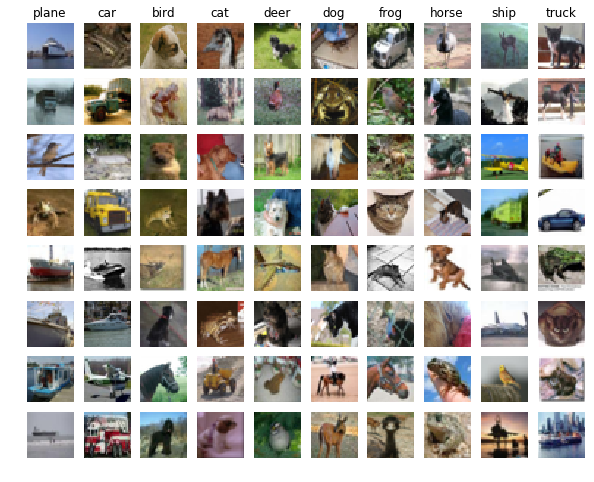

In [18]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [201]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-4, 2e-4, 5e-4, 1e-3]
standard_deviation = [1e-8, 1e-7]
#regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for std in standard_deviation:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=0.,
                              std=std, num_iters=1000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        trn_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, std)] = (trn_acc, val_acc)
        if val_acc > best_val:
            best_val, best_svm = val_acc, svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, std in sorted(results):
    train_accuracy, val_accuracy = results[(lr, std)]
    print('lr %e std %e train accuracy: %f val accuracy: %f' % (
                lr, std, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('lr %e std %e train accuracy: %f val accuracy: %f' % (
        lr, std, trn_acc, val_acc))

iteration 0 / 1000: loss 9.000000
iteration 100 / 1000: loss 8.242017
iteration 200 / 1000: loss 7.553807
iteration 300 / 1000: loss 7.026748
iteration 400 / 1000: loss 6.475273
iteration 500 / 1000: loss 5.823261
iteration 600 / 1000: loss 5.538577
iteration 700 / 1000: loss 5.236326
iteration 800 / 1000: loss 5.113630
iteration 900 / 1000: loss 4.999521
iteration 0 / 1000: loss 9.000000
iteration 100 / 1000: loss 8.240998
iteration 200 / 1000: loss 7.483008
iteration 300 / 1000: loss 6.949024
iteration 400 / 1000: loss 6.082878
iteration 500 / 1000: loss 5.867858
iteration 600 / 1000: loss 5.248862
iteration 700 / 1000: loss 5.087418
iteration 800 / 1000: loss 5.192405
iteration 900 / 1000: loss 4.962182
iteration 0 / 1000: loss 9.000000
iteration 100 / 1000: loss 7.532592
iteration 200 / 1000: loss 6.354661
iteration 300 / 1000: loss 5.565810
iteration 400 / 1000: loss 5.253952
iteration 500 / 1000: loss 4.941618
iteration 600 / 1000: loss 4.526753
iteration 700 / 1000: loss 4.37561

In [196]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

lr = 1e-3
reg = 0.2

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
svm = LinearSVM()
loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      std=1e-7, num_iters=1000, verbose=True)
y_train_pred = svm.predict(X_train_feats)
y_val_pred = svm.predict(X_val_feats)
trn_acc = np.mean(y_train == y_train_pred)
val_acc = np.mean(y_val == y_val_pred)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, trn_acc, val_acc))

iteration 0 / 1000: loss 8.999997
iteration 100 / 1000: loss 5.386266
iteration 200 / 1000: loss 4.096011
iteration 300 / 1000: loss 3.835129
iteration 400 / 1000: loss 4.121335
iteration 500 / 1000: loss 3.586746
iteration 600 / 1000: loss 3.918165
iteration 700 / 1000: loss 4.205015
iteration 800 / 1000: loss 3.344337
iteration 900 / 1000: loss 3.419557
lr 1.000000e-03 reg 2.000000e-01 train accuracy: 0.492184 val accuracy: 0.485000


In [199]:
# Evaluate your trained SVM on the test set
best_svm = svm
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.486


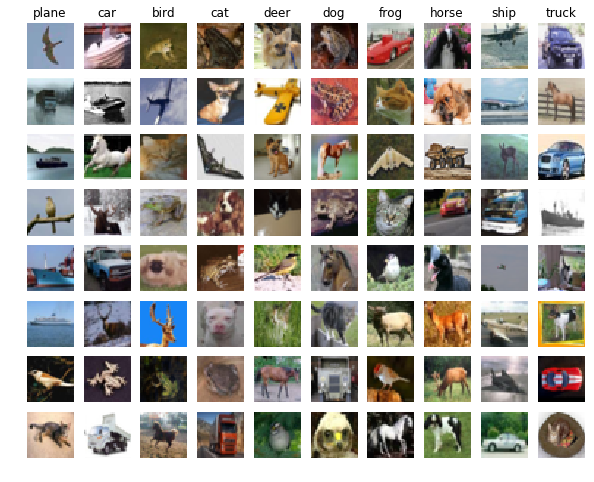

In [200]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [33]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

lr = 1e-3
reg = 0.5

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
svm = LinearSVM()
loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      std=1e-7, num_iters=1000, verbose=True)
y_train_pred = svm.predict(X_train_feats)
y_val_pred = svm.predict(X_val_feats)
trn_acc = np.mean(y_train == y_train_pred)
val_acc = np.mean(y_val == y_val_pred)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, trn_acc, val_acc))

iteration 0 / 1000: loss 9.000000
iteration 100 / 1000: loss 5.672343
iteration 200 / 1000: loss 4.666929
iteration 300 / 1000: loss 4.326711
iteration 400 / 1000: loss 4.382547
iteration 500 / 1000: loss 4.700850
iteration 600 / 1000: loss 4.816902
iteration 700 / 1000: loss 4.406252
iteration 800 / 1000: loss 4.139553
iteration 900 / 1000: loss 4.278306
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 0.489245 val accuracy: 0.488000


In [34]:
# Evaluate your trained SVM on the test set
best_svm = svm
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.486


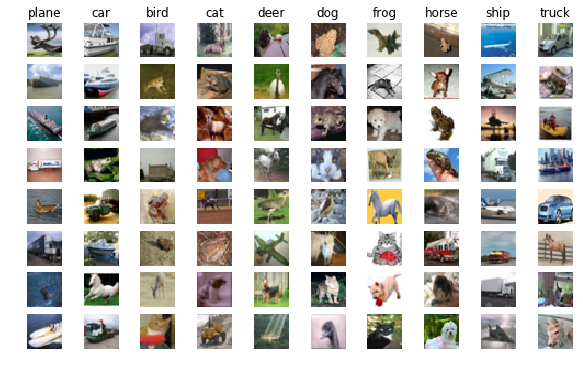

In [35]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,6))
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Answer**:
They make some sense. We can observe the classifier can catch some characteristics of each category, but confused by their common features. For example, in those misclassified below 'plane', we can see some bird (with wings) and ship (with blue backgroud) that have common features to plane. Similar phenomena can be seen in other misclassified categories.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [75]:
from cs231n.classifiers.neural_net import *

input_dim = X_train_feats.shape[1]
hidden_dim = 1000
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes, dropout_rate=0.2,
                  init_mode='deep')

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200, optimizer='nag',
            learning_rate=1e-1, learning_rate_decay=0.9,
            reg=0., verbose=True)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
with open('best_net.pkl', 'rb') as f:
    net = pickle.load(f, encoding='latin1')
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)
test_acc = (net.predict(X_test_feats) == y_test).mean()
print('Test accuracy: ', test_acc)

iteration 0 / 2000: loss 2.559215
iteration 100 / 2000: loss 1.894957
iteration 200 / 2000: loss 1.734024
Saving the best model so far...
iteration 300 / 2000: loss 1.433270
iteration 400 / 2000: loss 1.704688
Saving the best model so far...
iteration 500 / 2000: loss 1.301008
iteration 600 / 2000: loss 1.405128
iteration 700 / 2000: loss 1.411850
Saving the best model so far...
iteration 800 / 2000: loss 1.285509
iteration 900 / 2000: loss 1.398108
Saving the best model so far...
iteration 1000 / 2000: loss 1.140592
iteration 1100 / 2000: loss 1.238671
iteration 1200 / 2000: loss 1.355354
Saving the best model so far...
iteration 1300 / 2000: loss 1.223627
iteration 1400 / 2000: loss 1.412168
Saving the best model so far...
iteration 1500 / 2000: loss 1.056836
iteration 1600 / 2000: loss 1.120112
iteration 1700 / 2000: loss 1.006159
Saving the best model so far...
iteration 1800 / 2000: loss 1.016571
iteration 1900 / 2000: loss 1.122156
Saving the best model so far...
Saving the best 

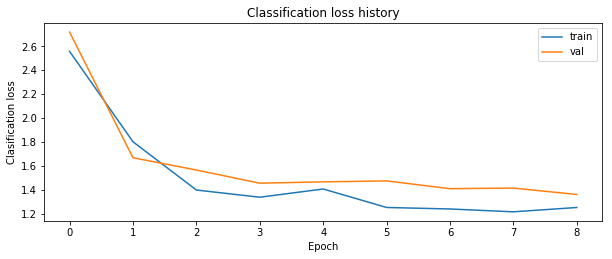

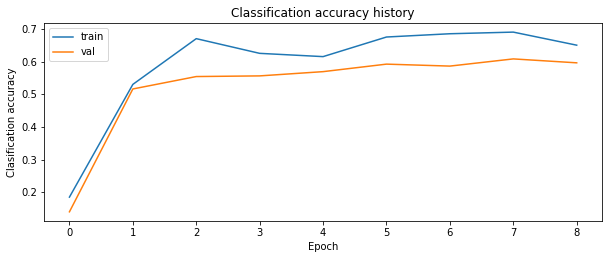

In [76]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(stats['train_loss'], label='train')
plt.plot(stats['val_loss'], label='val')
plt.title('Classification loss history')
plt.xlabel('Epoch')
plt.ylabel('Clasification loss')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc'], label='train')
plt.plot(stats['val_acc'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [106]:
from cs231n.classifiers.neural_net import *

input_dim = X_train_feats.shape[1]
hidden_dim = 1000
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes, init_mode='deep')

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200, optimizer='nag',
            learning_rate=1e-1, learning_rate_decay=0.9,
            reg=0.001, verbose=True)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
with open('best_net.pkl', 'rb') as f:
    net = pickle.load(f, encoding='latin1')
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)
test_acc = (net.predict(X_test_feats) == y_test).mean()
print('Test accuracy: ', test_acc)

iteration 0 / 2000: loss 4.522870
iteration 100 / 2000: loss 2.879690
iteration 200 / 2000: loss 2.304483
Saving the best model so far...
iteration 300 / 2000: loss 1.782225
iteration 400 / 2000: loss 1.743782
Saving the best model so far...
iteration 500 / 2000: loss 1.425740
iteration 600 / 2000: loss 1.430581
iteration 700 / 2000: loss 1.351026
Saving the best model so far...
iteration 800 / 2000: loss 1.255393
iteration 900 / 2000: loss 1.308673
Saving the best model so far...
iteration 1000 / 2000: loss 1.242196
iteration 1100 / 2000: loss 1.254642
iteration 1200 / 2000: loss 1.314367
Saving the best model so far...
iteration 1300 / 2000: loss 1.127104
iteration 1400 / 2000: loss 1.340313
Saving the best model so far...
iteration 1500 / 2000: loss 1.048617
iteration 1600 / 2000: loss 1.210996
iteration 1700 / 2000: loss 1.292658
Saving the best model so far...
iteration 1800 / 2000: loss 1.059035
iteration 1900 / 2000: loss 1.122898
Saving the best model so far...
Saving the best 

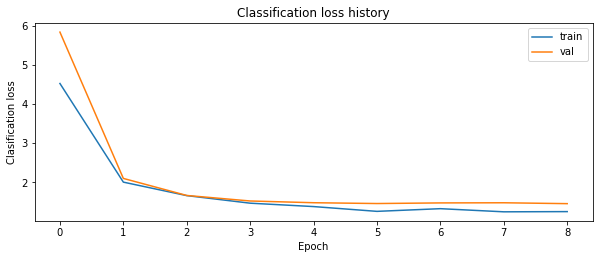

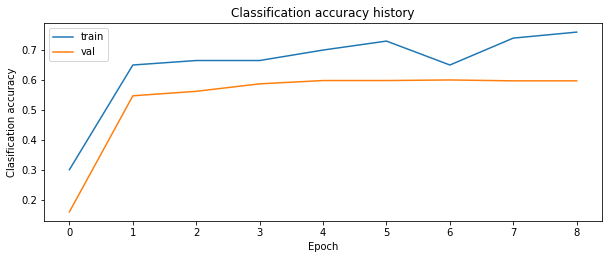

In [107]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(stats['train_loss'], label='train')
plt.plot(stats['val_loss'], label='val')
plt.title('Classification loss history')
plt.xlabel('Epoch')
plt.ylabel('Clasification loss')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc'], label='train')
plt.plot(stats['val_acc'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(['train', 'val'], loc='best')
plt.show()

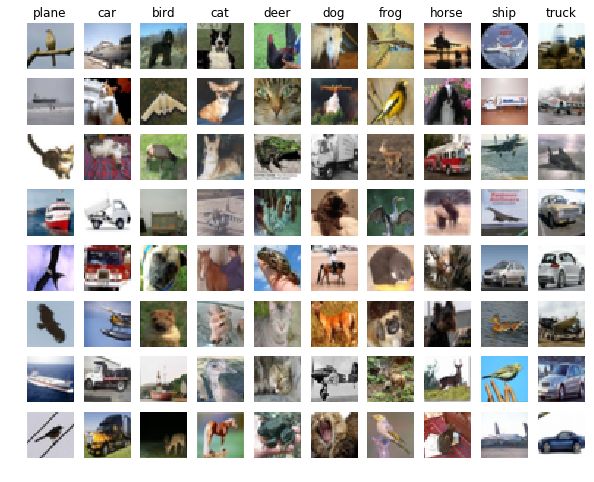

In [108]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

y_test_pred = net.predict(X_test_feats)
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!